# CS280 Programming Assignment 2
Implementing the Backpropagation Algorithm
<br>

Define architecture of Neural Network

In [125]:
NUM_INPUT = 3 #354 floats per datapoint in data.csv
NUM_HIDDEN1_NEURONS = 7
NUM_HIDDEN2_NEURONS = 5
NUM_OUTPUT = 3

Define the Learning Rate, LR:

In [126]:
LR = 0.1

Declare the matrices for the weights and biases, and then initialize them with random numbers:

In [127]:
import numpy as np
INIT_RANGE = 0.1


x_in = np.zeros((NUM_INPUT, 1))

w_h1 = np.random.uniform(low=-INIT_RANGE, high=INIT_RANGE, size=(NUM_HIDDEN1_NEURONS, NUM_INPUT))
b_h1 = np.random.uniform(low=-INIT_RANGE, high=INIT_RANGE, size=(NUM_HIDDEN1_NEURONS, 1))

w_h2 = np.random.uniform(low=-INIT_RANGE, high=INIT_RANGE, size=(NUM_HIDDEN2_NEURONS, NUM_HIDDEN1_NEURONS))
b_h2 = np.random.uniform(low=-INIT_RANGE, high=INIT_RANGE, size=(NUM_HIDDEN2_NEURONS, 1))

w_out = np.random.uniform(low=-INIT_RANGE, high=INIT_RANGE, size=(NUM_OUTPUT, NUM_HIDDEN2_NEURONS))
b_out = np.random.uniform(low=-INIT_RANGE, high=INIT_RANGE, size=(NUM_OUTPUT, 1))

d_out = np.zeros((NUM_OUTPUT, 1))

Training Phase:

In [128]:
train_data = np.array([[0, 0, 0],
                       [0, 0, 1],
                       [0, 1, 0],
                       [0, 1, 1],
                       [1, 0, 0],
                       [1, 0, 1],
                       [1, 1, 0],
                       [1, 1, 1]])
train_labels = np.array([[0, 0, 0],
                       [1, 1, 0],
                       [1, 0, 1],
                       [0, 1, 1],
                       [0, 1, 1],
                       [1, 0, 0],
                       [1, 1, 0],
                       [0, 0, 0]])

In [129]:
train_data.shape, train_data[2]

((8, 3), array([0, 1, 0]))

In [130]:
MAX_EPOCH = 30000
total_error = np.zeros((MAX_EPOCH, 1))
ERR_REPORT_PERIOD = 500 # Print error report every __ epochs
ERR_TERMINATION_COND = 0.0010000000000

In [131]:
training_ending_epoch = MAX_EPOCH
epochs = range(0, MAX_EPOCH)
for epoch_index in epochs:
    #print("EPOCH %d: "%(epoch_index+1))
    train_indices = np.random.permutation(train_data.shape[0])
    for train_index in train_indices:
    #for train_index, value in enumerate(train_data):
        # READ DATA
        x_in = train_data[train_index].reshape(-1, 1)
        d_out = train_labels[train_index].reshape(-1, 1)
        #print("x_in = X[%d] = "%(train_index), x_in)
        ##### FORWARD PASS #####
        ## HIDDEN LAYER 1
        v_h1 = np.dot(w_h1,x_in) + b_h1
        y_h1 = 1/(1 + np.exp(-v_h1))
        #print('w_h1 shape=', w_h1.shape, ' x_in shape=', x_in.shape, ' b_h1 shape=', b_h1.shape, ' v_h1 shape=', v_h1.shape, ' y_h1 shape=', y_h1.shape)
        ## HIDDEN LAYER 2
        v_h2 = np.dot(w_h2, y_h1) + b_h2
        y_h2 = 1/(1 + np.exp(-v_h2))
        #print('w_h2 shape=', w_h2.shape, ' y_h1 shape=', y_h1.shape, ' b_h2 shape=', b_h2.shape, ' v_h2 shape=', v_h2.shape, ' y_h2 shape=', y_h2.shape)
        ## OUTPUT LAYER
        v_out = np.dot(w_out, y_h2) + b_out
        out = 1/(1 + np.exp(-v_out))
        #print('w_out shape=', w_out.shape, ' y_h2 shape=', y_h2.shape, ' b_out shape=', b_out.shape, ' v_out shape=', v_out.shape, ' out shape=', out.shape)
        
        ##### BACK PROPAGATION #####
        #print('d_out shape=', d_out.shape)
        error = d_out - out
        #print('error: ', error, '\n')
        delta_out = error*out*(1-out)
        #print('delta-out.shape=',delta_out.shape)
        #print('(1-y_h2).shape=',(1-y_h2).shape, ' y_h2*(1-y_h2).shape=', (y_h2*(1-y_h2)).shape, ' np.dot(w_out,delta_out).shape=', (np.dot(np.transpose(w_out),delta_out)).shape)
        delta_h2 = (y_h2*(1-y_h2))*(np.dot(np.transpose(w_out),delta_out))
        delta_h1 = (y_h1*(1-y_h1))*(np.dot(np.transpose(w_h2), delta_h2))
        
        ## Update the weights and biases
        w_out = w_out + LR*delta_out*np.transpose(y_h2)
        b_out = b_out + LR*delta_out
        #print('UPDATED w_out.shape=', w_out.shape, 'UPDATED b_out.shape=', b_out.shape)
        w_h2 = w_h2 + LR*delta_h2*np.transpose(y_h1)
        b_h2 = b_h2 + LR*delta_h2
        #print('UPDATED w_h2.shape=', w_h2.shape, 'UPDATED b_h2.shape=', b_h2.shape)
        w_h1 = w_h1 + LR*delta_h1*np.transpose(x_in)
        b_h1 = b_h1 + LR*delta_h1
        #print('UPDATED w_h1.shape=', w_h1.shape, 'UPDATED b_h1.shape=', b_h1.shape)
    total_error[epoch_index] = total_error[epoch_index] + np.sum(error*error)
    if epoch_index % ERR_REPORT_PERIOD == 0:
        print('EPOCH %d total_error=%10.12f'%(epoch_index,total_error[epoch_index]))
    if total_error[epoch_index] < ERR_TERMINATION_COND:
        training_ending_epoch = epoch_index
        break

print('\n\n--\nTRAINING ENDED AT EPOCH %d WITH total_error=%10.12f'%(training_ending_epoch, total_error[training_ending_epoch]))
        

        

EPOCH 0 total_error=0.815908097344
EPOCH 500 total_error=0.656306606272
EPOCH 1000 total_error=0.651304640973
EPOCH 1500 total_error=0.906510199633
EPOCH 2000 total_error=0.649281761495
EPOCH 2500 total_error=0.904146578065
EPOCH 3000 total_error=0.899219013508
EPOCH 3500 total_error=0.890747446787
EPOCH 4000 total_error=0.673067781170
EPOCH 4500 total_error=0.598670792715
EPOCH 5000 total_error=0.569821946163
EPOCH 5500 total_error=0.473788213715
EPOCH 6000 total_error=0.566746692305
EPOCH 6500 total_error=0.527367306085
EPOCH 7000 total_error=0.520785797353
EPOCH 7500 total_error=0.535146289224
EPOCH 8000 total_error=0.526945408122
EPOCH 8500 total_error=1.252599404825
EPOCH 9000 total_error=0.478042492934
EPOCH 9500 total_error=0.731420327992
EPOCH 10000 total_error=0.829499989564
EPOCH 10500 total_error=0.440881135687
EPOCH 11000 total_error=0.274807133761
EPOCH 11500 total_error=0.127341602449
EPOCH 12000 total_error=0.164533827275
EPOCH 12500 total_error=0.049828905362
EPOCH 1300

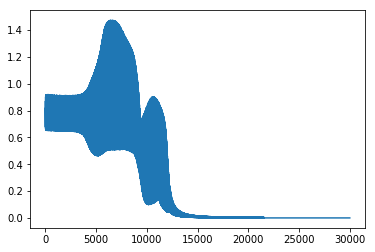

In [132]:
import matplotlib.pyplot as plt
plt.plot(epochs, total_error)
#plt.axis([0, training_ending_epoch, 0, np.max(total_error)])
plt.show()